# Tutorial Subsample

## Open
We are going to open 2 of the oceandatasets available on SciServer:
* Almansi et al., 2017 - Rectilinear grid
* Test curvilinear grid

Some of the oceandatasets can be opened with different options. Check out the documentation!

In [1]:
import oceanspy as ospy
od_rect = ospy.open_oceandataset.EGshelfIIseas2km_ERAI()
od_curv = ospy.open_oceandataset.exp_Arctic_Control()

Opening [EGshelfIIseas2km_ERAI]:
[High-resolution (~2km) numerical simulation covering the east Greenland shelf (EGshelf), and the Iceland and Irminger Seas (IIseas)]
Opening [exp_Arctic_Control]:
[Curvilinear grid test. Setup by Dr. Renske Gelderloos]


Here is how an oceandataset looks like:

In [2]:
od_rect

<oceanspy.OceanDataset>

Main attributes:
   .name: EGshelfIIseas2km_ERAI
   .description: High-resolution (~2km) numerical simulation covering the east Greenland shelf (EGshelf), and the Iceland and Irminger Seas (IIseas)
   .dataset: <xarray.Dataset>
   .grid: <xgcm.Grid>

More attributes:
   .parameters: <class 'dict'>
   .grid_coords: <class 'dict'>

Let's plot the bathymetry of the two datasets.

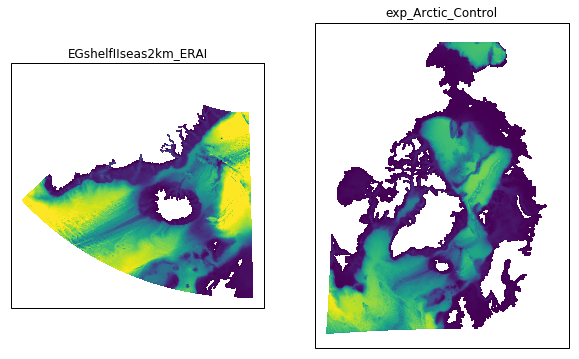

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%matplotlib inline

proj = ccrs.NorthPolarStereo()
fig, axes = plt.subplots(1, 2, subplot_kw=dict(projection=proj), figsize=(10, 10))
for i, (ax, od) in enumerate(zip(axes, [od_rect, od_curv])):
    ax.pcolormesh(od.dataset['XC'].values, 
                  od.dataset['YC'].values, 
                  od.dataset['Depth'].where(od.dataset['Depth']>0).values, 
                  transform=ccrs.PlateCarree())
    ax.set_title(od.name)

## Subsample

### Cutout
The domain of the oceandataset with curvilinear grid is larger than the model with rectilinear grid.  
Let's use OceanSpy to cutout an oceandataset preserving the original grid structure. 

Cutting out the oceandataset


/home/idies/miniconda3/lib/python3.6/site-packages/dask/local.py:253: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


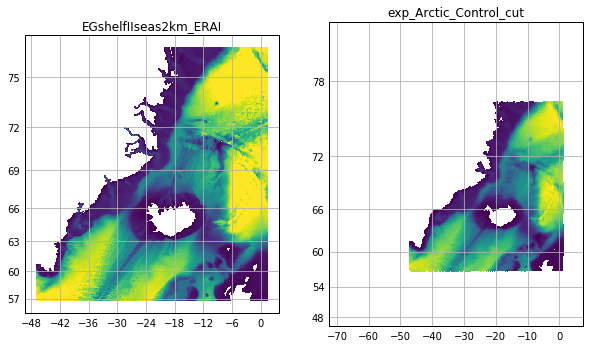

In [4]:
# Cutout
YRange = od_rect.dataset['Yp1'].values
XRange = od_rect.dataset['Xp1'].values
od_curv_cut = ospy.subsample.cutout(od_curv, YRange=YRange, XRange=XRange, mask_outside=True) 
od_curv_cut = od_curv_cut.set_name('cut', overwrite=False)
# If you like a more compact syntax, this command would do exactly the same:
# od_curv_cut = od_curv.cutout(YRange=YRange, XRange=XRange, mask_outside=True).set_name('cut', overwrite=False)

# Plot
proj = ccrs.Mercator()
fig, axes = plt.subplots(1, 2, subplot_kw=dict(projection=proj), figsize=(10, 10))
for i, (ax, od) in enumerate(zip(axes, [od_rect, od_curv_cut])):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xlabels_top   = False
    gl.ylabels_right = False
    ax.pcolormesh(od.dataset['XC'].values, 
                  od.dataset['YC'].values, 
                  od.dataset['Depth'].where(od.dataset['Depth']>0).values, 
                  transform=ccrs.PlateCarree())
    ax.set_title(od.name)

We can cutout both time and space, and upsample in time.  
Let's extract monthly snapshots of Sea Surface Temperature:

Cutting out the oceandataset


/home/idies/workspace/Storage/malmans2/persistent/oceanspy/oceanspy/_oceandataset.py:859: UserWarning: 
Time resampling drops variables on `time_midp` dimension. 
Dropped variables: ['time_midp'].
  self = _subsample.cutout(od = self, **kwargs)


CPU times: user 7.77 s, sys: 9.88 s, total: 17.6 s
Wall time: 15.4 s


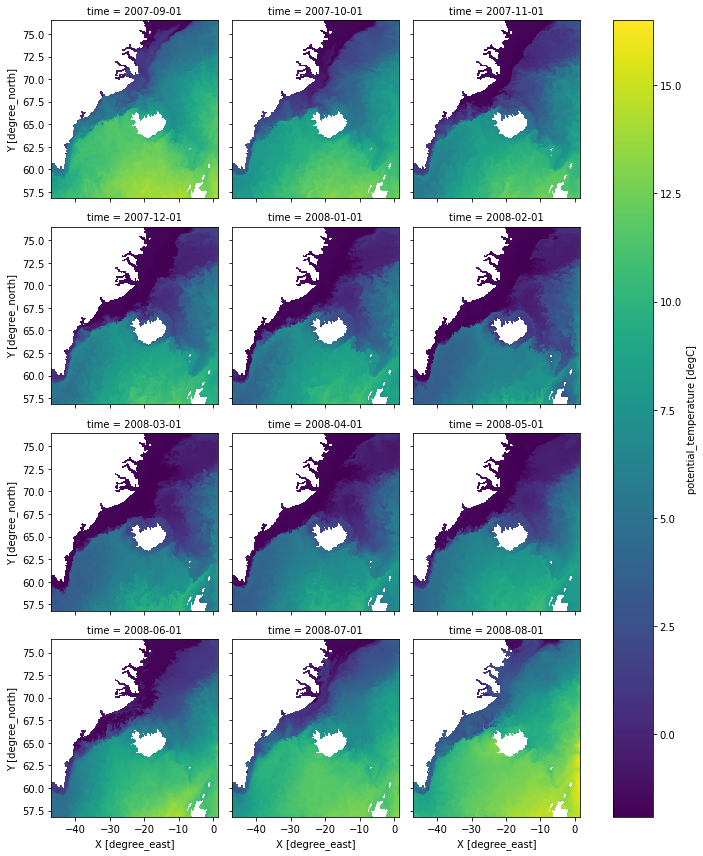

In [5]:
%%time
# Time shows that cutting out and plotting is quick. 
# It takes some time to display the figure in the notebook because it's quite heavy.
od_SST_mothly = od_rect.cutout(ZRange=0, timeFreq='1M', varList='Temp', sampMethod='snapshot')
od_SST_mothly = od_SST_mothly.set_name('SST_montly', overwrite=False)
od_SST_mothly.dataset['Temp'].isel(Z=0).plot(col='time', col_wrap=3, center=False)

### Mooring
Mooring array paths follow the model grid.  
Note that you can use any argument of `subsample.cutout` to reduce your oceandataset first.

In [6]:
lats_Kogur = [ 68.68,  67.52,  66.49]
lons_Kogur = [-26.28, -23.77, -22.99]
od_rect_mooring = od_rect.mooring_array(Ymoor=lats_Kogur, Xmoor=lons_Kogur, 
                                        varList=['Temp', 'U', 'V'], 
                                        timeFreq='1M', 
                                        ZRange=[0, -2000]).set_name('mooring', overwrite=False)
od_curv_mooring = od_curv.mooring_array(Ymoor=lats_Kogur, Xmoor=lons_Kogur, 
                                        varList=['Temp', 'U', 'V'], 
                                        timeRange=['2028-01', '2029-01'], 
                                        ZRange=[0, -2000]).set_name('mooring', overwrite=False)

Cutting out the oceandataset


/home/idies/workspace/Storage/malmans2/persistent/oceanspy/oceanspy/_oceandataset.py:859: UserWarning: 
Time resampling drops variables on `time_midp` dimension. 
Dropped variables: ['time_midp'].
  self = _subsample.cutout(od = self, **kwargs)


Extracting mooring array
Cutting out the oceandataset
Extracting mooring array


Let's plot the mean temperature of monthly snapshots, and the mooring locations.

/home/idies/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/idies/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


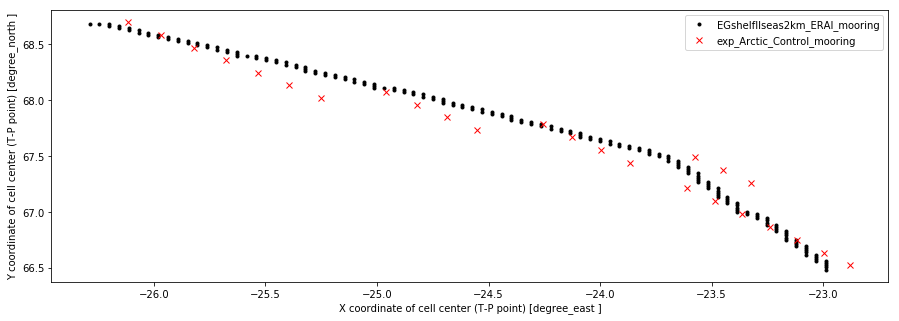

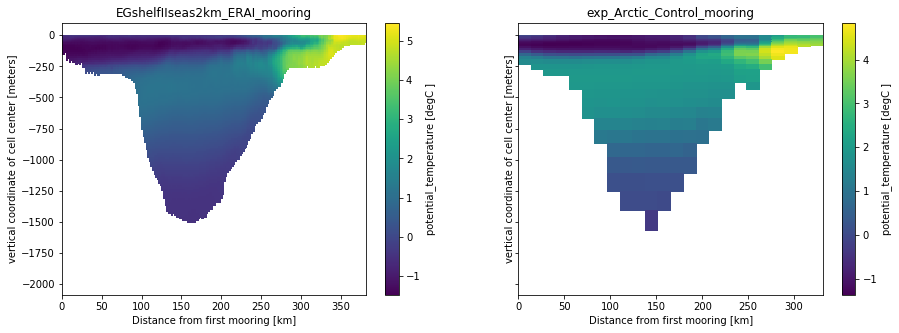

In [7]:
ods = [od_rect_mooring, od_curv_mooring]
figsize = (15, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

for i, (od, marker) in enumerate(zip(ods, ['k.', 'rx'])):
    ax.plot(od.dataset['XC'].squeeze(), od.dataset['YC'].squeeze(), marker, label=od.name)
_ = ax.legend()
_ = ax.set_ylabel(od.dataset['YC'].attrs['description']+' ['+od.dataset['YC'].attrs['units']+' ]')
_ = ax.set_xlabel(od.dataset['XC'].attrs['description']+' ['+od.dataset['XC'].attrs['units']+' ]')

fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
for i, (ax, od) in enumerate(zip(axes, ods)):
    dist_name = 'mooring_dist'
    pcol = ax.pcolormesh(od.dataset[dist_name].values,
                         od.dataset['Z'].values,
                         od.dataset['Temp'].where(od.dataset['Temp']!=0).mean('time').squeeze().values)
    ax.set_title(od.name)
    ax.set_xlabel(od.dataset[dist_name].attrs['long_name']+' ['+od.dataset[dist_name].attrs['units']+']')
    ax.set_ylabel(od.dataset['Z'].attrs['long_name']+' ['+od.dataset['Z'].attrs['units']+']')
    plt.colorbar(pcol, ax=ax, label=od.dataset['Temp'].attrs['long_name']+' ['+od.dataset['Temp'].attrs['units']+' ]')

An important feature of this subsampling method is that every mooring has the same structure of the original grid.  
Therefore, every mooring will have 1 C point (cell center. E.g., temperature or salinity), 2 U points (Cell faces. E.g., X component of the velocity), 2 V points (Cell faces. E.g., Y component of the velocities), and 4 G points (Cell corners. E.g., vertical component of relative vorticity).  
Let's plot a bunch of moorings to show the new grid:

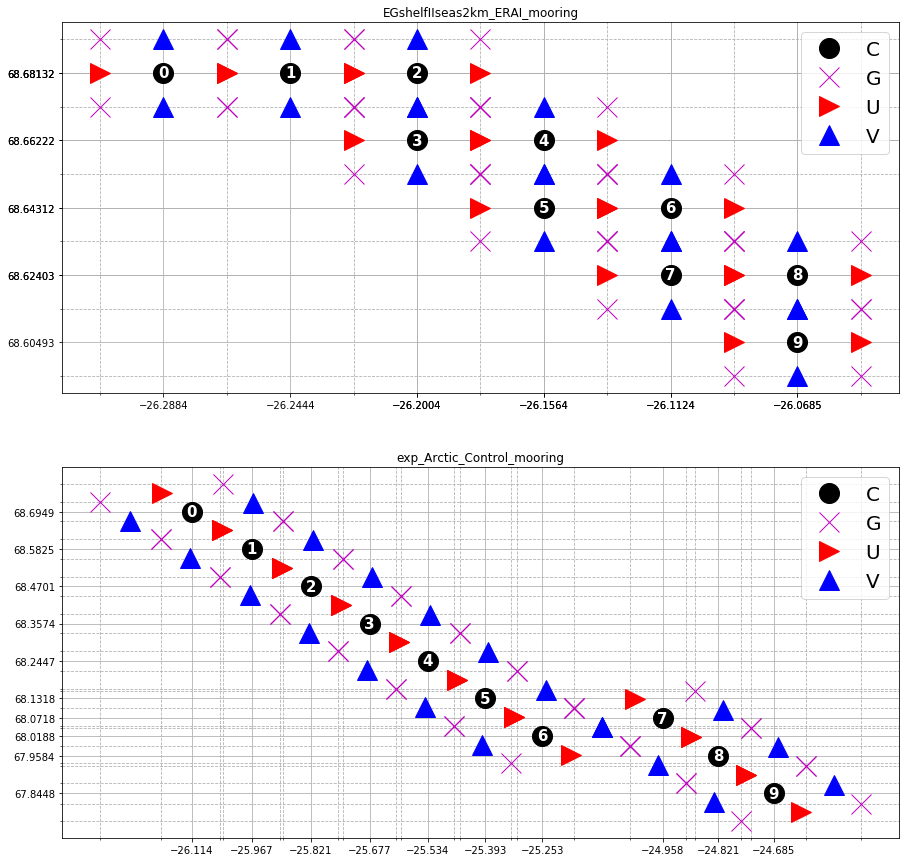

In [8]:
import numpy as np
num_of_moorings = 10
fig, axes = plt.subplots(2, 1, figsize=(15, 15))
for _, (ax, od) in enumerate(zip(axes, ods)):
    for i, (pos, mark, col) in enumerate(zip(['C', 'G', 'U', 'V'],
                                             ['o', 'x', '>', '^'],
                                             ['k', 'm', 'r', 'b'])):
        ax.plot(od.dataset['X'+pos].isel(mooring=slice(num_of_moorings)).values.flatten(), 
                od.dataset['Y'+pos].isel(mooring=slice(num_of_moorings)).values.flatten(), col+mark,
                markersize = 20, label=pos)

    for i in range(num_of_moorings):
        ax.annotate(str(i), (od.dataset['XC'].isel(mooring=i).squeeze(),
                             od.dataset['YC'].isel(mooring=i).squeeze()), 
                    size=15, weight="bold", color='w', ha='center', va='center')
    ax.legend(prop={'size': 20})
    ax.set_xticks(od.dataset['XC'].isel(mooring=slice(num_of_moorings)).squeeze().values, minor=False)
    ax.set_yticks(od.dataset['YC'].isel(mooring=slice(num_of_moorings)).squeeze().values, minor=False)
    ax.set_xticks(np.unique(od.dataset['XG'].isel(mooring=slice(num_of_moorings)).squeeze().values), minor=True)
    ax.set_yticks(np.unique(od.dataset['YG'].isel(mooring=slice(num_of_moorings)).squeeze().values), minor=True)
    ax.grid(which='major', linestyle='-')
    ax.grid(which='minor', linestyle='--')
    ax.set_title(od.name)

The advantage of having the data organized in this way is that we can use `xgcm.Grid` (stored under `oceandataset.grid`), we can close budgets, we can look at volume or tracer transports, ...  
Let's plot the mean velocity magnitude at Kogur.  

/home/idies/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/idies/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


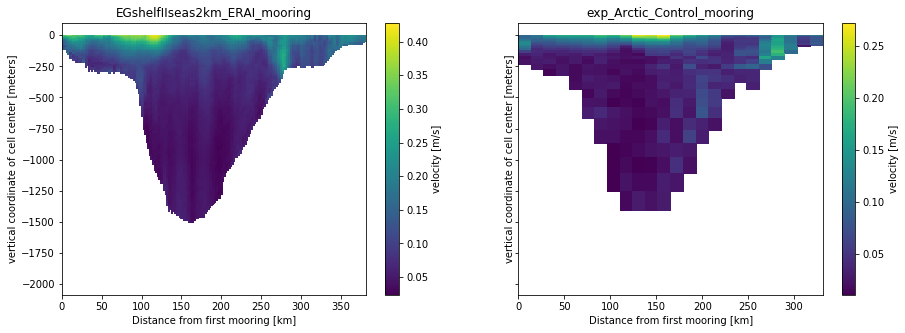

In [9]:
import xarray as xr
def add_vel_mooring(od):
    grid = od.grid
    U = grid.interp(od.dataset['U'], 'X')
    V = grid.interp(od.dataset['V'], 'Y')
    vel = xr.ufuncs.sqrt(U**2+V**2)
    vel.attrs['long_name'] = 'velocity'
    vel.attrs['units']     = 'm/s'
    od  = od.add_DataArray(vel.rename('vel'))
    return od

fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
for i, (ax, od) in enumerate(zip(axes, ods)):
    dist_name = 'mooring_dist'
    od   = add_vel_mooring(od)
    pcol = ax.pcolormesh(od.dataset[dist_name].values,
                         od.dataset['Z'].values,
                         od.dataset['vel'].where(od.dataset['vel']!=0).mean('time').squeeze().values)
    ax.set_title(od.name)
    ax.set_xlabel(od.dataset[dist_name].attrs['long_name']+' ['+od.dataset[dist_name].attrs['units']+']')
    ax.set_ylabel(od.dataset['Z'].attrs['long_name']+' ['+od.dataset['Z'].attrs['units']+']')
    plt.colorbar(pcol, ax=ax, label='velocity [m/s]')

### Survey

The difference with `subsample.mooring_array` is that `subsample.survey_stations` interpolates using `xesmf`, and returns all the data on the same horizontal grid (cell centers).  
Surveys follow great circle paths, and stations have constant distance between each other.

In [10]:
delta = 2
od_rect_survey = od_rect.survey_stations(Ysurv=lats_Kogur, Xsurv=lons_Kogur, delta=delta, 
                                         varList=['Temp', 'U', 'V'], 
                                         timeFreq='1M', 
                                         ZRange=[0, -2000]).set_name('survey', overwrite=False)
od_curv_survey = od_curv.survey_stations(Ysurv=lats_Kogur, Xsurv=lons_Kogur, delta=delta, 
                                         varList=['Temp', 'U', 'V'], 
                                         timeRange=['2028-01', '2029-01'], 
                                         ZRange=[0, -2000]).set_name('survey', overwrite=False)

Cutting out the oceandataset


/home/idies/workspace/Storage/malmans2/persistent/oceanspy/oceanspy/_oceandataset.py:859: UserWarning: 
Time resampling drops variables on `time_midp` dimension. 
Dropped variables: ['time_midp'].
  self = _subsample.cutout(od = self, **kwargs)


Carrying out survey


/home/idies/miniconda3/lib/python3.6/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "


Create weight file: bilinear_118x76_142x142.nc


/home/idies/miniconda3/lib/python3.6/site-packages/xesmf/smm.py:73: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


Remove file bilinear_118x76_142x142.nc
Cutting out the oceandataset
Carrying out survey
Create weight file: bilinear_25x21_142x142.nc


/home/idies/miniconda3/lib/python3.6/site-packages/xesmf/smm.py:73: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


Remove file bilinear_25x21_142x142.nc


Let's plot the mean temperature of monthly snapshots, and the station locations.

/home/idies/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/idies/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


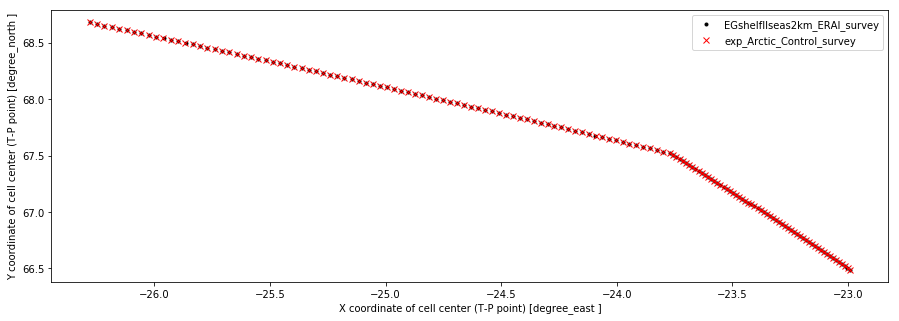

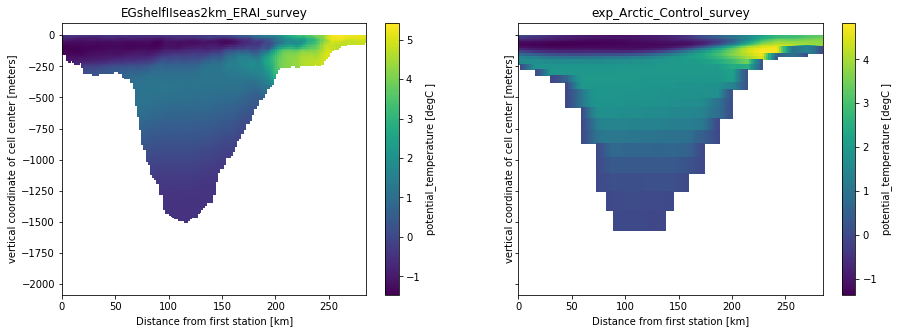

In [11]:
ods = [od_rect_survey, od_curv_survey]
figsize = (15, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

for i, (od, marker) in enumerate(zip(ods, ['k.', 'rx'])):
    ax.plot(od.dataset['XC'].squeeze(), od.dataset['YC'].squeeze(), marker, label=od.name)
_ = ax.legend()
_ = ax.set_ylabel(od.dataset['YC'].attrs['description']+' ['+od.dataset['YC'].attrs['units']+' ]')
_ = ax.set_xlabel(od.dataset['XC'].attrs['description']+' ['+od.dataset['XC'].attrs['units']+' ]')

fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
for i, (ax, od) in enumerate(zip(axes, ods)):
    dist_name = 'station_dist'
    pcol = ax.pcolormesh(od.dataset[dist_name].values,
                         od.dataset['Z'].values,
                         od.dataset['Temp'].where(od.dataset['Temp']!=0).mean('time').squeeze().values)
    ax.set_title(od.name)
    ax.set_xlabel(od.dataset[dist_name].attrs['long_name']+' ['+od.dataset[dist_name].attrs['units']+']')
    ax.set_ylabel(od.dataset['Z'].attrs['long_name']+' ['+od.dataset['Z'].attrs['units']+']')
    plt.colorbar(pcol, ax=ax, label=od.dataset['Temp'].attrs['long_name']+' ['+od.dataset['Temp'].attrs['units']+' ]')

All fields are on the same grid now, so we don't need to use `xgcm.Grid` to compute velocities.

/home/idies/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/idies/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


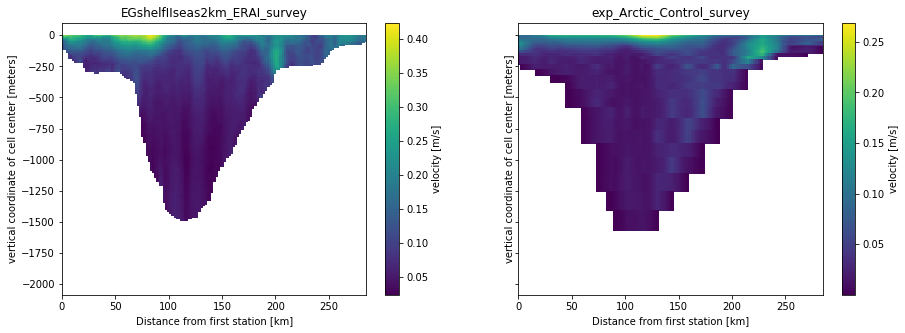

In [12]:
import xarray as xr

def add_vel_survey(od):
    U = od.dataset['U']
    V = od.dataset['V']
    vel = xr.ufuncs.sqrt(U**2+V**2)
    vel.attrs['long_name'] = 'velocity'
    vel.attrs['units']     = 'm/s'
    od  = od.add_DataArray(vel.rename('vel'))
    return od

fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
for i, (ax, od) in enumerate(zip(axes, ods)):
    dist_name = 'station_dist'
    od   = add_vel_survey(od)
    pcol = ax.pcolormesh(od.dataset[dist_name].values,
                         od.dataset['Z'].values,
                         od.dataset['vel'].where(od.dataset['vel']!=0).mean('time').squeeze().values)
    ax.set_title(od.name)
    ax.set_xlabel(od.dataset[dist_name].attrs['long_name']+' ['+od.dataset[dist_name].attrs['units']+']')
    ax.set_ylabel(od.dataset['Z'].attrs['long_name']+' ['+od.dataset['Z'].attrs['units']+']')
    plt.colorbar(pcol, ax=ax, label='velocity [m/s]')

Let's compare temperature of mooring arrays and surveys.

/home/idies/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/idies/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/idies/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/idies/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


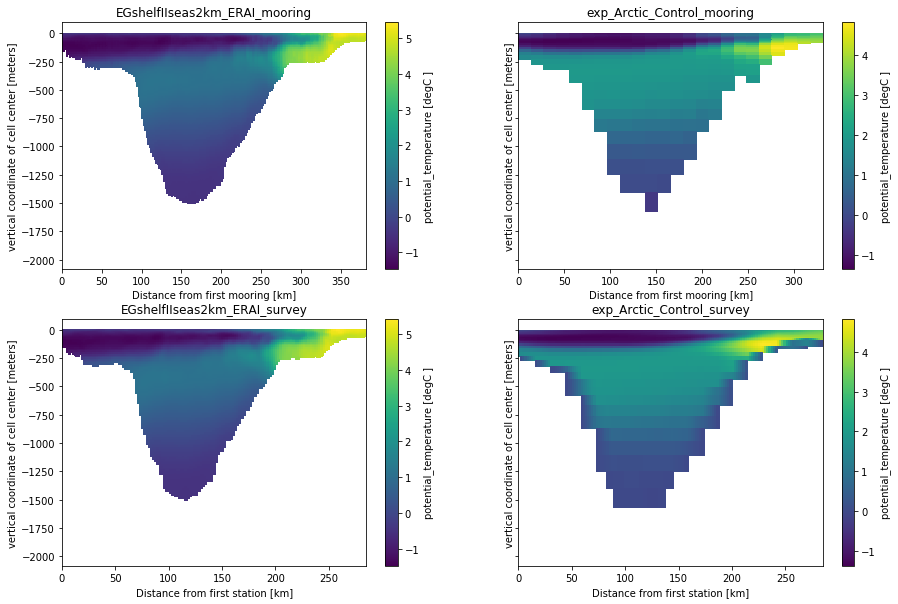

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
ods = [od_rect_mooring, od_curv_mooring, od_rect_survey, od_curv_survey]
for i, (ax, od) in enumerate(zip(axes.flatten(), ods)):
    if i<2: dist_name = 'mooring_dist'
    else:   dist_name = 'station_dist'
    pcol = ax.pcolormesh(od.dataset[dist_name].values,
                         od.dataset['Z'].values,
                         od.dataset['Temp'].where(od.dataset['Temp']!=0).mean('time').squeeze().values)
    ax.set_title(od.name)
    ax.set_xlabel(od.dataset[dist_name].attrs['long_name']+' ['+od.dataset[dist_name].attrs['units']+']')
    ax.set_ylabel(od.dataset['Z'].attrs['long_name']+' ['+od.dataset['Z'].attrs['units']+']')
    plt.colorbar(pcol, ax=ax, label=od.dataset['Temp'].attrs['long_name']+' ['+od.dataset['Temp'].attrs['units']+' ]')